# Problem-Specific Coordinate Generation for HyperNEAT Substrates

## Setup

The testing was done on a 16GB VRAM GPU with CUDA 12.8. VRAM usage is determined mainly by substrate and population size.

### Imports

This setup requires some dependencies, mainly TensorNEAT, JAX, numpy, matplotlib, NetworkX, scikit-learn and wandb for logging. Using a virtual environment (i.e. conda) is highly recommended. Python 3.10.18 was used in development and testing.

In [ ]:
import jax
import wandb

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate

from substrate_generation.pca_coor_generator import PCAanalyzer 
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.random_coor_generator import RandomCoordinateGenerator
from substrate_generation.data_sampling import sample_from_pretrained_agent
from evol_pipeline.brax_env import CustomBraxEnv
from evol_pipeline.custom_pipeline import CustomPipeline
from substrate_generation.hidden_layers import HiddenLayerGenerator
from utils.visualization import visualize_cppn, visualize_nn
from utils.utils import save_coordinates_to_csv, setup_folder_structure
from evol_pipeline.evol_algorithm import create_evol_algorithm

A quick setup of the folder structure to avoid errors further down the line.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

### Setup Environment

[Brax environments](https://github.com/google/brax/tree/main/brax/envs) are used for this experiment through the [TensorNEAT wrapper](https://github.com/EMI-Group/tensorneat/tree/main/src/tensorneat/problem/rl).

In [3]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]
max_dims = config["data_analysis"]["max_dims"](obs_size)

print("env_problem.input_shape: ", env_problem.input_shape)
print("env_problem.input_shape: ", env_problem.output_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-09-13 08:07:56.379049: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-13 08:08:07.413254: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

env_problem.input_shape:  (27,)
env_problem.input_shape:  (8,)


### Random Substrate

We also want to test if our data-driven approaches are better than arbritarily chosen coordinates in an equally high-dimensional space. For this purpose we generate a substrate with the given number of dimensions in which all coordinates are random binary combinations, e.g. (0,1,0,1,1,0).

In [ ]:
random_generator = RandomCoordinateGenerator(
    obs_size=obs_size,
    act_size=act_size,
    max_dims=max_dims,
    depth_factor=config["substrate"]["depth_factor"],
    width_factor=config["substrate"]["width_factor"],
)
input_coors, output_coors = random_generator.generate_io_coordinates()

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_double_hot`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.
* `shift_two`: This does the same as `shift`, but doubles the number of nodes by adding duplicates where all the directions are multiplied by 2. This is like treating it as a vector and simply doubling it.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift` and `shift_two` methods.

In [ ]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
    depth_factor=config["substrate"]["depth_factor"],
)

hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)

active_substrate = FullSubstrate(
    input_coors=input_coors,
    hidden_coors=hidden_coors,
    output_coors=output_coors,
)

## Neuroevolution

Finally the substrates are ready to be used for neuroevolution with HyperNEAT. Weights and Biases (wandb) is used for logging and the CPPNs with highest fitness and their phenotypes are visualized. Coordinates are logged for further analysis.


wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


initializing
initializing finished
start compile


2025-09-13 08:08:39.415005: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 10.99GiB (11797581604 bytes) by rematerialization; only reduced to 12.17GiB (13067371208 bytes), down from 12.61GiB (13539230432 bytes) originally


compile finished, cost time: 32.960090s
Generation: 1, Cost time: 7028.84ms
 	fitness: valid cnt: 600, max: 17.5659, min: -142.1715, mean: -77.1918, std: 35.8848

	node counts: max: 19, min: 17, mean: 18.08
 	conn counts: max: 47, min: 29, mean: 43.03
 	species: 20, [206, 16, 52, 19, 28, 14, 58, 4, 15, 18, 12, 24, 36, 14, 15, 4, 18, 29, 4, 14]

Generation: 2, Cost time: 7042.52ms
 	fitness: valid cnt: 600, max: 17.8579, min: -137.0985, mean: -66.1318, std: 41.5347

	node counts: max: 20, min: 16, mean: 18.09
 	conn counts: max: 48, min: 13, mean: 40.72
 	species: 20, [38, 27, 21, 27, 69, 35, 70, 23, 34, 13, 22, 81, 10, 41, 31, 2, 6, 7, 15, 28]

Generation: 3, Cost time: 6981.55ms
 	fitness: valid cnt: 600, max: 29.3097, min: -152.6638, mean: -44.7056, std: 44.1058

	node counts: max: 21, min: 16, mean: 18.14
 	conn counts: max: 50, min: 1, mean: 38.55
 	species: 20, [56, 60, 33, 19, 44, 11, 30, 19, 50, 26, 19, 29, 17, 61, 3, 10, 34, 17, 3, 59]

Generation: 4, Cost time: 7009.29ms
 	fit

compute_ms,▃▃▃▃▃▄▂▂▂▁▁▂▁▁▂▂▂▂▃▃▄▄▅▆▄▅▆▇▆▆▇▇███▇▆▆▇▇
fitness_max,▁▁▂▂▃▄▃▃▄▄▄▄▆▅▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇
fitness_mean,▁▁▂▂▂▄▄▄▄▅▅▅▅▄▅▅▅▅▅▅▅▆▆▆▆▇▇▆▆▇▆▆▆▇▇▇█▇▇▇
fitness_min,▂▇▅▂▆▄▄▇▆▅▇▅▅▄▅▇▆▆▃▆█▃▆▄▇▁▂▅▅▅▄▇▆▄▆▇▅▆▆▄
fitness_std,▁▂▂▂▃▃▃▂▃▃▃▃▃▄▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇▇▇▇███▇█▇
generation,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
compute_ms,7248.0576
fitness_max,292.05405
fitness_mean,48.96309
fitness_min,-157.74754
fitness_std,99.2395


Total reward:  -31.377468


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_cycle1.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_cycle1.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 7072 potential connections.
Visualizing 634 connections. Excluded loops. Weight threshold: 0.1


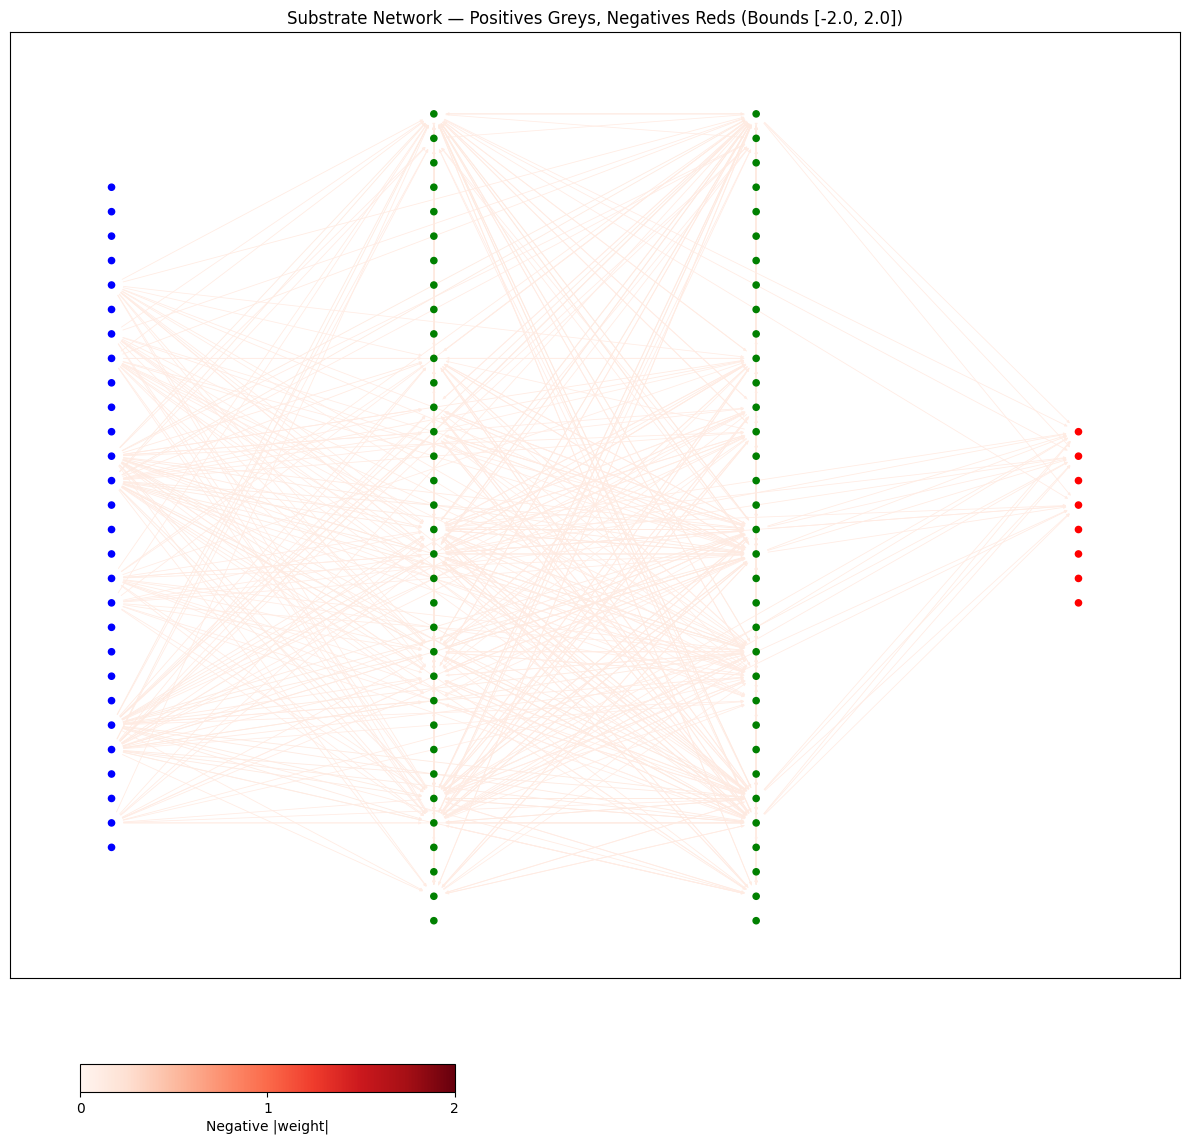

Visualization saved to: output/ant/topology/nn_cycle1.svg
Successfully saved coordinates to: output/ant/coordinates/cycle1_io.csv
Causal expert data collection finished.

Running PCA to find feature dimensions covering 70.0% of variance (with a hard limit of 6 dimensions)...
PCA found 9 dimensions needed for 70.0% variance.
Applying max limit. Final number of feature dimensions: 6
Normalizing coordinates...
Added layering dimension. Final coordinate size: 7
PCA variance plot saved to: output/ant/data_analysis/pca_variance_70_cycle1.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_70_cycle1.png


initializing
initializing finished
start compile


2025-09-13 08:33:28.167621: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 10.99GiB (11797581604 bytes) by rematerialization; only reduced to 12.17GiB (13067371208 bytes), down from 12.61GiB (13539230432 bytes) originally


compile finished, cost time: 33.269418s
Generation: 1, Cost time: 6917.83ms
 	fitness: valid cnt: 600, max: 20.0035, min: -146.9903, mean: -74.8805, std: 37.2725

	node counts: max: 19, min: 17, mean: 18.08
 	conn counts: max: 47, min: 29, mean: 43.03
 	species: 20, [222, 16, 24, 10, 51, 14, 10, 21, 12, 37, 19, 21, 4, 23, 18, 37, 11, 3, 7, 40]

Generation: 2, Cost time: 7013.68ms
 	fitness: valid cnt: 600, max: 49.5474, min: -144.6486, mean: -61.5525, std: 42.1236

	node counts: max: 20, min: 17, mean: 18.16
 	conn counts: max: 49, min: 15, mean: 41.93
 	species: 20, [49, 5, 71, 38, 40, 39, 25, 39, 22, 22, 31, 16, 34, 15, 24, 64, 11, 11, 11, 33]

Generation: 3, Cost time: 7071.74ms
 	fitness: valid cnt: 600, max: 48.9795, min: -142.6404, mean: -41.3349, std: 44.6911

	node counts: max: 20, min: 16, mean: 18.10
 	conn counts: max: 48, min: 14, mean: 40.11
 	species: 20, [49, 11, 19, 17, 40, 42, 34, 28, 59, 21, 42, 44, 46, 17, 20, 10, 22, 15, 9, 55]

Generation: 4, Cost time: 7043.48ms
 

compute_ms,▁▂▃▅▅▅▅▅▄▄▅▅▅▄▄▅▅▅▅▅▆▆▅▅▅▅▆▄▄▅▇▇████▆▆▆▄
fitness_max,▁▂▃▃▃▄▄▃▄▅▅▅▅▆▄▆▅▆▇▇▆▇▇███▇▆▇▆█▆▆▆▇▇▇▇▇▇
fitness_mean,▁▄▅▅▅▅▅▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇▇▆▇█▇▆
fitness_min,▅▃▅▇▆▇▇▅▅▇█▆▆▄▇▆▆▇█▆▆▇▄▇█▆▆▅▅▆▇▃▆▅▁▇▅█▆▇
fitness_std,▁▂▂▂▂▄▄▅▅▅▅▅▅▅▄▅▅▅▄▅▆▆▆▆▆▆▆▅▆▆▅▇▆▆▆▇███▇
generation,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
compute_ms,7300.99916
fitness_max,442.02588
fitness_mean,58.14318
fitness_min,-200.4279
fitness_std,120.96947


Total reward:  489.856


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_cycle2.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_cycle2.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 7072 potential connections.
Visualizing 3039 connections. Excluded loops. Weight threshold: 0.1


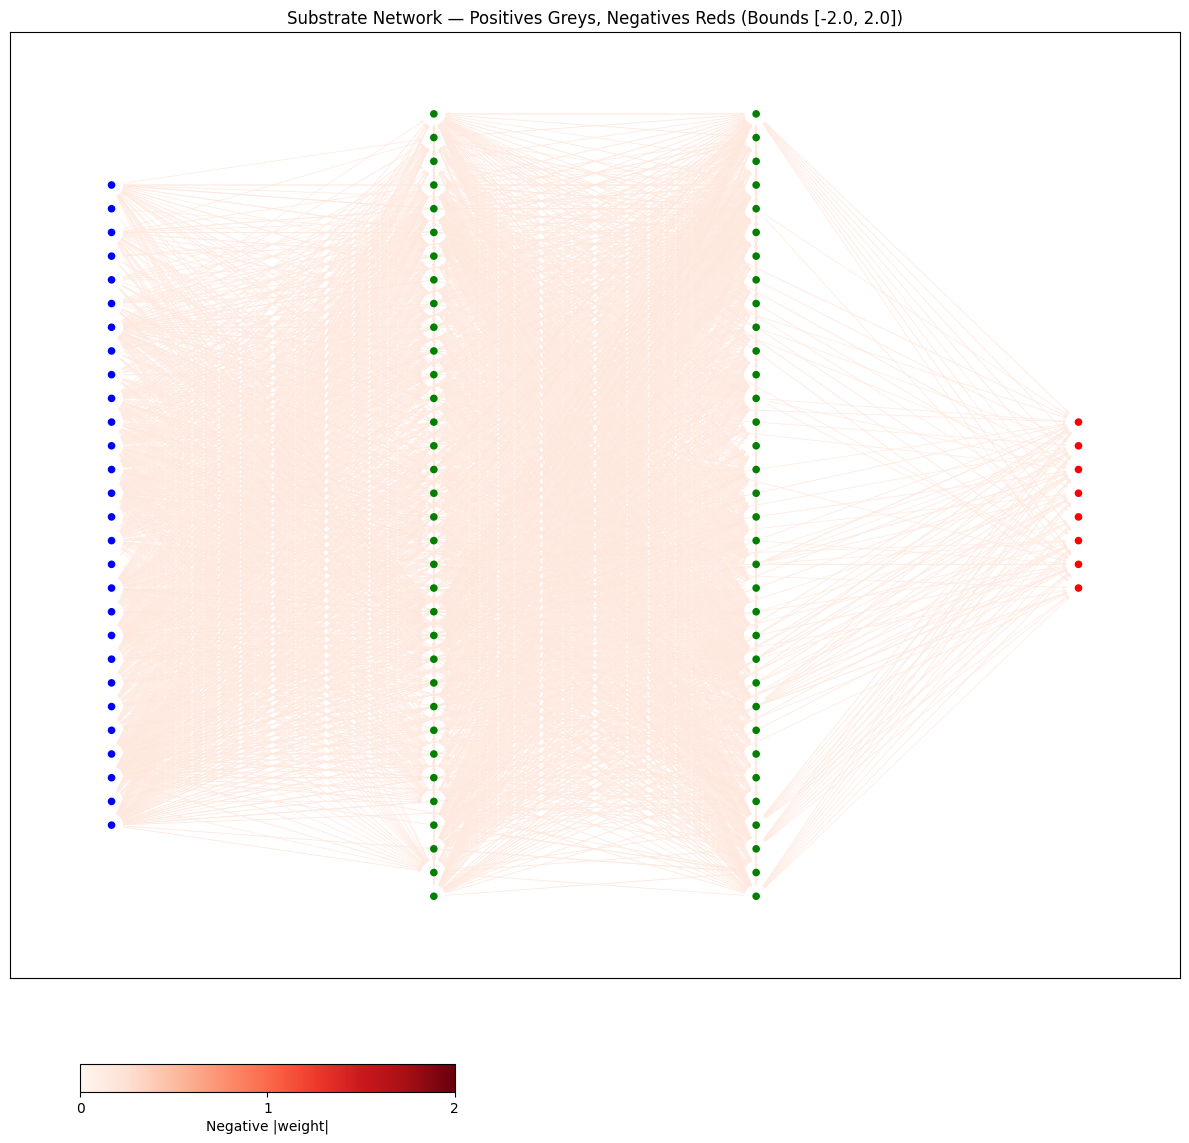

Visualization saved to: output/ant/topology/nn_cycle2.svg
Successfully saved coordinates to: output/ant/coordinates/cycle2_io.csv
Causal expert data collection finished.

Running PCA to find feature dimensions covering 75.0% of variance (with a hard limit of 6 dimensions)...
PCA found 8 dimensions needed for 75.0% variance.
Applying max limit. Final number of feature dimensions: 6
Normalizing coordinates...
Added layering dimension. Final coordinate size: 7
PCA variance plot saved to: output/ant/data_analysis/pca_variance_75_cycle2.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_75_cycle2.png


initializing
initializing finished
start compile


2025-09-13 09:23:50.785594: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 10.99GiB (11797581604 bytes) by rematerialization; only reduced to 12.17GiB (13067371208 bytes), down from 12.61GiB (13539230432 bytes) originally


compile finished, cost time: 33.921322s
Generation: 1, Cost time: 7050.01ms
 	fitness: valid cnt: 600, max: 21.0925, min: -148.8028, mean: -76.9944, std: 34.9947

	node counts: max: 19, min: 17, mean: 18.08
 	conn counts: max: 47, min: 29, mean: 43.03
 	species: 18, [303, 21, 7, 29, 18, 17, 4, 85, 17, 25, 3, 13, 1, 3, 17, 9, 6, 22]

Generation: 2, Cost time: 7052.39ms
 	fitness: valid cnt: 600, max: 11.0474, min: -157.5579, mean: -64.5972, std: 39.6091

	node counts: max: 20, min: 16, mean: 18.08
 	conn counts: max: 48, min: 13, mean: 40.59
 	species: 20, [40, 35, 40, 59, 39, 48, 73, 17, 109, 13, 31, 17, 19, 10, 13, 4, 3, 1, 6, 23]

Generation: 3, Cost time: 7072.67ms
 	fitness: valid cnt: 600, max: 37.4385, min: -132.6433, mean: -47.3711, std: 42.1798

	node counts: max: 21, min: 15, mean: 17.81
 	conn counts: max: 49, min: 0, mean: 36.29
 	species: 20, [36, 46, 31, 44, 33, 30, 5, 33, 56, 23, 50, 41, 24, 20, 34, 7, 3, 9, 7, 68]

Generation: 4, Cost time: 7121.79ms
 	fitness: valid cnt

compute_ms,▁▂▂▂▂▃▅▄▃▇▆▄▃▅▇▂▂▂▂█▄▃▅▅▆▆▆▆▅▅▅▆▅▅▅▅▅▄▄▃
fitness_max,▁▃▄▄▄▆▅▅▅▆▆▆▆▇▇▅▆▆▆▇▇▇█▇▅██▅█▅▆▇▅▅▆▆▅▄▄▄
fitness_mean,▁▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██▇▇▇███▇█▇▇█▇████
fitness_min,▇▇▆▇▇█▆▆▇▅▆▇▄▆▆▇▆▁▅▅▆▇▅▆▆█▆▃▄▇▇▆▆▄▇▃▇▇▇▄
fitness_std,▁▁▂▄▃▃▃▃▂▃▂▄▄▅▆▆▅▆▆▇▆▆▆▇▆▇▆▆▆▇▇▇▇▇██▇█▇▇
generation,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇█████
compute_ms,7464.32257
fitness_max,250.58882
fitness_mean,51.44003
fitness_min,-146.81744
fitness_std,89.6252


Total reward:  629.6024


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_cycle3.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_cycle3.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 7072 potential connections.
Visualizing 1734 connections. Excluded loops. Weight threshold: 0.1


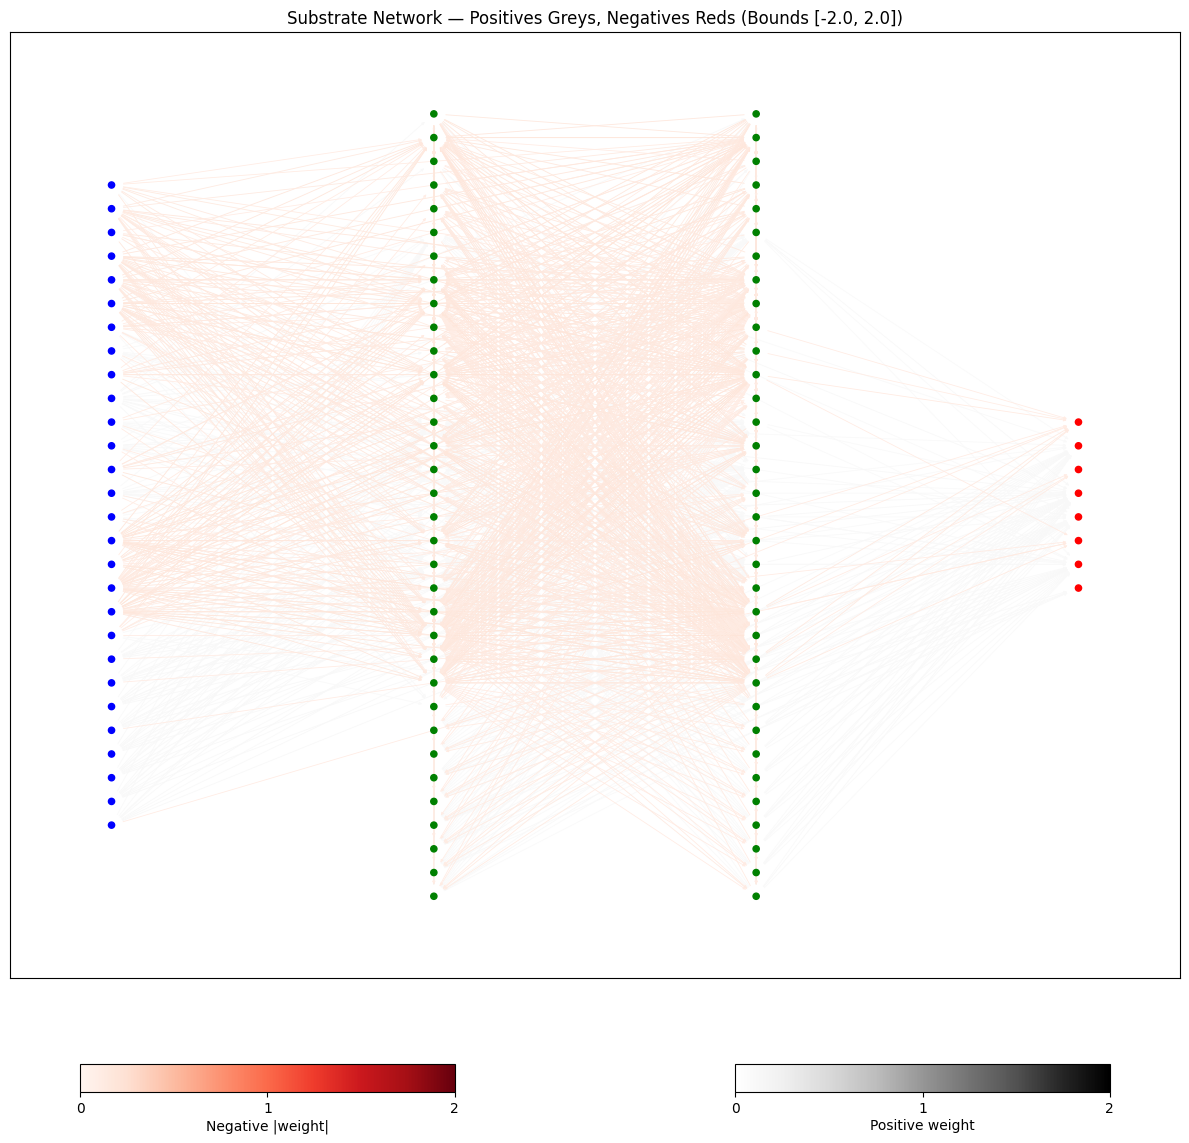

Visualization saved to: output/ant/topology/nn_cycle3.svg
Successfully saved coordinates to: output/ant/coordinates/cycle3_io.csv
Causal expert data collection finished.

Running PCA to find feature dimensions covering 80.0% of variance (with a hard limit of 6 dimensions)...
PCA found 11 dimensions needed for 80.0% variance.
Applying max limit. Final number of feature dimensions: 6
Normalizing coordinates...
Added layering dimension. Final coordinate size: 7
PCA variance plot saved to: output/ant/data_analysis/pca_variance_80_cycle3.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_80_cycle3.png


In [ ]:
for i in range(3):

    evol_algorithm = create_evol_algorithm(substrate=active_substrate)

    substrate_dimensions = int(active_substrate.query_coors.shape[1]/2)

    wanbd_name = f"{env_name}_cycle{i+1}_{substrate_dimensions}d"
    wandb_tags = [config["substrate"]["hidden_layer_type"], env_name, "cycles"]

    wandb.init(
        name=wanbd_name,
        project="substrate_dims",
        tags=wandb_tags,
        config=config  
    )

    wandb.config.update({
        "substrate": {
            "obs_size": obs_size,
            "act_size": act_size,
            "substrate.query_coors.shape": active_substrate.query_coors.shape, # (num_queries, query_dim)
            "algorithm.num_inputs": evol_algorithm.num_inputs,
            }
        }
    )

    pipeline = CustomPipeline(
        algorithm=evol_algorithm,
        problem=env_problem,
        seed=config["experiment"]["seed"],
        generation_limit=["evolution"]["generation_limit"],
        fitness_target=config["evolution"]["fitness_target"],
        is_save=False,
        save_dir=config["experiment"]["output_dir"],
    )

    init_state = pipeline.setup()
    state = pipeline.auto_run(state=init_state)

    print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

    wandb.finish()

    state_for_show = state[0] if isinstance(state, tuple) else state

    # Transform the best genome into network parameters
    best_genome = pipeline.best_genome

    # Built-in show method to produce and save a video of the agent
    pipeline.show(
        state=state_for_show,
        best=best_genome,
        output_type="mp4",
        save_path=f"{OUTPUT_DIR}/video/agent_cycle{i+1}.mp4",
    )

    # Visualizes the CPPN
    visualize_cppn(
        pipeline=pipeline, 
        state=state, 
        save_path=f"{OUTPUT_DIR}/topology/cppn_cycle{i+1}.svg"
        )
    # Visualizes a representation of the neural network in 2D space
    visualize_nn(
        pipeline=pipeline, 
        state=state, 
        save_path=f"{OUTPUT_DIR}/topology/nn_cycle{i+1}.svg", 
        substrate=active_substrate, 
        input_coors=input_coors, 
        hidden_coors=hidden_coors, 
        output_coors=output_coors,
        hidden_depth=config["substrate"]["hidden_depth"], 
        weight_lower_limit=config["algorithm"]["conn_weight_lower_bound"], 
        weight_upper_limit=config["algorithm"]["conn_weight_upper_bound"]
        )
    
    # all input and output coordinates are logged for further analysis
    log_coors = input_coors
    for coor in hidden_coors:
        log_coors.append(coor)
    for coor in output_coors:
        log_coors.append(coor)
    save_coordinates_to_csv(
        coordinates=log_coors,
        filepath=f"{OUTPUT_DIR}/coordinates/cycle{i+1}_io.csv",
    )

    key = jax.random.PRNGKey(config["experiment"]["seed"]) # Use seed from config
    sampled_expert_data = sample_from_pretrained_agent(key, state, best_genome, pipeline, env_problem, 1000)

    analyzer_fa = FactorAnalyzer(
        data=sampled_expert_data, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=max_dims,
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"],
        normalize_coors=config["data_analysis"]["normalize_coors"],
        depth_factor=config["substrate"]["depth_factor"],
    )
    input_coors, output_coors = analyzer_fa.generate_io_coordinates()
    analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap__cycle{i+1}.png")
    hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)

    active_substrate = FullSubstrate(
    input_coors=input_coors,
    hidden_coors=hidden_coors,
    output_coors=output_coors,
    )